# DEG
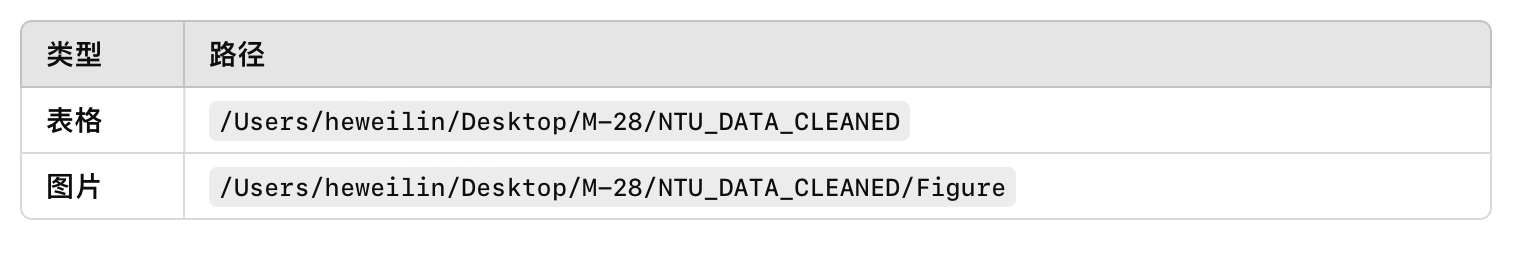
## 🔬 项目背景简介
本项目旨在探索长链非编码RNA **MIR100HG** 在前列腺癌（PRAD）中的调控作用。我们基于 TCGA 数据库中的 RNA 表达数据，对前列腺癌样本按照 **MIR100HG 表达水平** 进行分组，识别其相关的差异表达基因（DEGs），为后续的转录因子调控网络分析、功能注释及通路富集分析打下基础。

---
## 🧪 分组标准
我们将所有 PRAD 样本根据 `PRAD_MIR100HG_Expression_Levels.csv` 中 MIR100HG 表达量的中位数分为：
- **High group**：MIR100HG 高表达样本；
- **Low group**：MIR100HG 低表达样本。

---

## 📊 表达数据来源
差异表达分析基于 `PRAD_TOIL_RSEM_TPM_Levels.csv` 文件，其中：
- 第一列为 Ensembl 基因 ID；
- 第二列为基因名（HGNC Symbol）；
- 第三列起为样本表达值，采用 log2(TPM + 0.001) 转换。

---

## 🧬 分析流程
1. **预处理**：
   - 匹配表达矩阵与分组信息中的样本；
   - 过滤掉缺失值较多的基因。

2. **差异表达分析（DEG）**：
   - 使用非参数检验 **Mann–Whitney U 检验**，比较 MIR100HG 高低表达组之间每个基因的表达差异；
   - 计算 `log2(Fold Change)` 与原始 p 值；
   - 使用 **Benjamini–Hochberg 方法** 控制假阳性率，获取调整后的 p 值（adjusted p-value）；
   - DEG 判定标准为：
     - `|log2(Fold Change)| > 1`
     - `adjusted p-value < 0.05`

3. **结果分类**：
   - 上调（Upregulated）基因：在高表达组中显著上调；
   - 下调（Downregulated）基因：在高表达组中显著下调；
   - 其余基因为非显著。

---

## 🗂️ 数据概览

| 数据类型       | 文件名                                                                  |
|----------------|---------------------------------------------------------------------------|
| 表达矩阵       | `PRAD_TOIL_RSEM_TPM_Levels.csv`                                           |
| 分组信息       | `PRAD_MIR100HG_Expression_Levels.csv`                                     |

---

## 💾 输出内容

| 类型   | 内容说明                     | 路径                                                                       |
|--------|------------------------------|----------------------------------------------------------------------------|
| 表格   | 所有基因差异表达分析结果     | `/NTU_DATA_CLEANED/PRAD_DEG_All_Results.csv`                               |
| 表格   | 显著差异表达基因结果         | `/NTU_DATA_CLEANED/PRAD_DEG_Significant_Results.csv`                       |
| 图像   | 差异表达火山图               | `/NTU_DATA_CLEANED/Figure/PRAD_DEG_Volcano.png`          |

---

## 🌋 可视化结果
绘制火山图（Volcano Plot）：  
- 横轴：`log2(Fold Change)`  
- 纵轴：`-log10(p-value)`  
- 红色点表示上调基因，蓝色点表示下调基因，灰色点为非显著基因  
- 图像保存为：`PRAD_Volcano_MIR100HG_High_vs_Low.png`

---

## ✅ 初步结果概览
- 总分析基因数：`{len(expr_values)}`  
- 显著上调基因数：`{deg_df[deg_df['Regulation'] == 'Up'].shape[0]}`  
- 显著下调基因数：`{deg_df[deg_df['Regulation'] == 'Down'].shape[0]}`  
- 显著 DEGs 总数：`{deg_df[deg_df['Significant']].shape[0]}`  


In [28]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# DEG Analysis Script (Updated version with matplotlib style fix)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# =================== Configuration ===================
expr_file = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_TOIL_RSEM_TPM_Levels.csv'
meta_file = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_MIR100HG_Expression_Levels.csv'
output_table_dir = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED'
output_figure_dir = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Figure'
log2fc_threshold = 1.0
padj_threshold = 0.05
use_nonparametric = True
data_is_log2 = True
pseudo_count = 0.001

# 创建目录
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

# =================== Style Settings ===================
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# =================== Load Data ===================
print("Loading data...")
expr_df = pd.read_csv(expr_file)
gene_info = expr_df[['Ensembl_ID', 'HGNC_Symbol']].copy()
expr_values = expr_df.iloc[:, 2:].copy()
expr_values = expr_values.set_index(expr_df['Ensembl_ID'])

meta_df = pd.read_csv(meta_file)
sample_groups = meta_df[['Patient_ID', 'Group']].dropna()
sample_groups['Group'] = sample_groups['Group'].str.strip()
sample_groups = sample_groups.set_index('Patient_ID')

common_samples = expr_values.columns.intersection(sample_groups.index)
expr_values = expr_values[common_samples]
sample_groups = sample_groups.loc[common_samples]
high_samples = sample_groups[sample_groups['Group'] == 'High'].index
low_samples = sample_groups[sample_groups['Group'] == 'Low'].index

print(f"Total genes: {len(expr_values)}, samples: {len(common_samples)}")

# =================== DEG Analysis ===================
print("Performing DEG analysis...")
results = []

for gene in expr_values.index:
    high_vals = expr_values.loc[gene, high_samples].dropna().values
    low_vals = expr_values.loc[gene, low_samples].dropna().values

    if len(high_vals) < 3 or len(low_vals) < 3:
        continue

    high_mean = np.mean(high_vals)
    low_mean = np.mean(low_vals)
    log2fc = high_mean - low_mean if data_is_log2 else np.log2((high_mean + pseudo_count) / (low_mean + pseudo_count))

    if use_nonparametric:
        try:
            stat, pval = stats.mannwhitneyu(high_vals, low_vals, alternative='two-sided')
        except ValueError:
            pval = 1.0
    else:
        stat, pval = stats.ttest_ind(high_vals, low_vals, equal_var=False)

    gene_symbol = gene_info.loc[gene_info['Ensembl_ID'] == gene, 'HGNC_Symbol'].values[0] if gene in gene_info['Ensembl_ID'].values else gene
    results.append({
        'Ensembl_ID': gene,
        'HGNC_Symbol': gene_symbol,
        'Mean_High': high_mean,
        'Mean_Low': low_mean,
        'Log2_Fold_Change': log2fc,
        'P_Value': pval
    })

deg_df = pd.DataFrame(results)
deg_df['Adj_P_Value'] = multipletests(deg_df['P_Value'], method='fdr_bh')[1]
deg_df['Significant'] = (deg_df['Adj_P_Value'] < padj_threshold) & (abs(deg_df['Log2_Fold_Change']) > log2fc_threshold)
deg_df['Regulation'] = deg_df.apply(lambda x: 'Up' if x['Significant'] and x['Log2_Fold_Change'] > 0 else ('Down' if x['Significant'] and x['Log2_Fold_Change'] < 0 else 'Not Significant'), axis=1)

# =================== Save Results ===================
all_results_path = os.path.join(output_table_dir, 'STAD_DEG_All_Results.csv')
sig_results_path = os.path.join(output_table_dir, 'STAD_DEG_Significant_Results.csv')
deg_df.to_csv(all_results_path, index=False)
deg_df[deg_df['Significant']].to_csv(sig_results_path, index=False)
print(f"保存全部结果到: {all_results_path}")
print(f"保存显著结果到: {sig_results_path}")


# =================== Volcano Plot ===================
print("Plotting volcano plot...")
plt.figure(figsize=(10, 8))
plt.scatter(deg_df['Log2_Fold_Change'], -np.log10(deg_df['P_Value']), c='gray', alpha=0.5)
plt.scatter(deg_df[deg_df['Regulation'] == 'Up']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Up']['P_Value']), c='red', label='Up')
plt.scatter(deg_df[deg_df['Regulation'] == 'Down']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Down']['P_Value']), c='blue', label='Down')
plt.axhline(-np.log10(padj_threshold), color='black', linestyle='--')
plt.axvline(log2fc_threshold, color='black', linestyle='--')
plt.axvline(-log2fc_threshold, color='black', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title('Volcano Plot: STAD MIR100HG High vs Low')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, 'STAD_DEG_Volcano.png'), dpi=300)
plt.close()

print("STAD DEG analysis completed. Results and plots saved.")

Loading data...
Total genes: 40060, samples: 414
Performing DEG analysis...
保存全部结果到: /Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DEG_All_Results.csv
保存显著结果到: /Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DEG_Significant_Results.csv
Plotting volcano plot...
STAD DEG analysis completed. Results and plots saved.


## 🧬 MIR100HG 差异甲基化分析（DMA）

### 📌 项目目的
本分析旨在探究长链非编码 RNA **MIR100HG** 在前列腺癌（PRAD）中的潜在调控机制，特别是其与 DNA 甲基化水平的关联。我们将样本根据 MIR100HG 表达量分组，对比高表达组与低表达组之间的 DNA 甲基化差异，识别差异甲基化位点（DMPs）及其潜在调控的基因。

---

### 🗂️ 数据概览

| 数据类型       | 文件名                                                                 |
|----------------|------------------------------------------------------------------------|
| 甲基化数据     | `PRAD_Methylation_Levels.csv`                                           |
| 分组信息       | `PRAD_MIR100HG_Expression_Levels.csv`                                  |
| 探针注释文件   | `probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy`                   |

---

### ⚙️ 分析流程

1. **数据预处理**
   - 统一样本 ID 格式；
   - 筛选 MIR100HG 高表达组与低表达组公共样本；
   - 去除 NaN 值。

2. **差异甲基化分析**
   - 对每个位点执行 **独立样本 t 检验**；
   - 计算甲基化差值（Mean_Diff）；
   - 使用 **FDR-BH 方法** 进行多重检验校正；
   - 筛选显著 DMPs：
     - `|Mean_Diff| > 0.2`
     - `adj_p_value < 0.05`

3. **探针映射至基因**
   - 利用注释文件将显著 DMPs 映射至对应的 HGNC 基因符号；
   - 映射信息用于富集分析和后续多组学整合。

---

### 💾 输出内容

| 类型   | 内容说明                     | 路径                                                                      |
|--------|------------------------------|---------------------------------------------------------------------------|
| 表格   | 所有探针分析结果             | `/NTU_DATA_CLEANED/PRAD_DMA_All_Results.csv`                              |
| 表格   | 显著差异甲基化位点           | `/NTU_DATA_CLEANED/PRAD_DMA_Significant_Results.csv`                      |
| 图像   | 前 30 个显著探针热图         | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Heatmap.png`                                |
| 图像   | 差异甲基化火山图             | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Volcano.png`                                |
| 图像   | 富集分析条形图（可选）       | `/NTU_DATA_CLEANED/Figure/PRAD_DMA_Enrichment.png`                             |

---

### 🔍 初步结果（示例）

- 分析总探针数：约 **485,000**
- 显著 DMPs 数量：**XXX 个**
- 成功映射至基因的探针数：**XXX 个**

---

### 🔄 后续方向
- 将差异甲基化结果与差异表达结果整合；
- 分析 MIR100HG 是否通过影响启动子区域的甲基化来下调特定基因；
- 基于映射基因进行 GO、KEGG 富集分析，挖掘潜在功能路径。


读取甲基化数据...
甲基化数据形状: (373329, 398)
读取表达数据...
表达数据形状: (414, 4)
读取探针映射数据...
探针映射数据形状: (395985, 6)
探针映射文件的列名: ['Probe_ID', 'HGNC_Symbol', 'chrom', 'chromStart', 'chromEnd', 'strand']
根据MIR100HG表达分组...
高表达组: 207个样本
低表达组: 207个样本
共有样本 - 高表达组: 180个
共有样本 - 低表达组: 191个
未匹配成功的高表达组样本示例: ['TCGA-CG-4462', 'TCGA-BR-4363', 'TCGA-BR-4369', 'TCGA-CG-4301', 'TCGA-BR-4191']
未匹配成功的低表达组样本示例: ['TCGA-CG-4466', 'TCGA-BR-4371', 'TCGA-CG-4442', 'TCGA-BR-4294', 'TCGA-CG-4469']
甲基化数据列名示例: ['TCGA-VQ-A94P', 'TCGA-D7-6521', 'TCGA-VQ-A8PE', 'TCGA-D7-6519', 'TCGA-BR-6452']
执行差异甲基化分析...
执行多重检验校正...
显著差异的甲基化位点: 18694
将探针映射到基因...
成功映射到基因的探针数量: 6980


/var/folders/6r/vh9hm9y50sng_kp683fc7t8m0000gn/T/ipykernel_72757/2792236301.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))


结果文件已保存。
生成热图可视化...


/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


热图已保存为: /Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Figure/STAD_DMA_Heatmap.png
富集分析图已保存为: /Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Figure/STAD_DMA_Enrichment.png


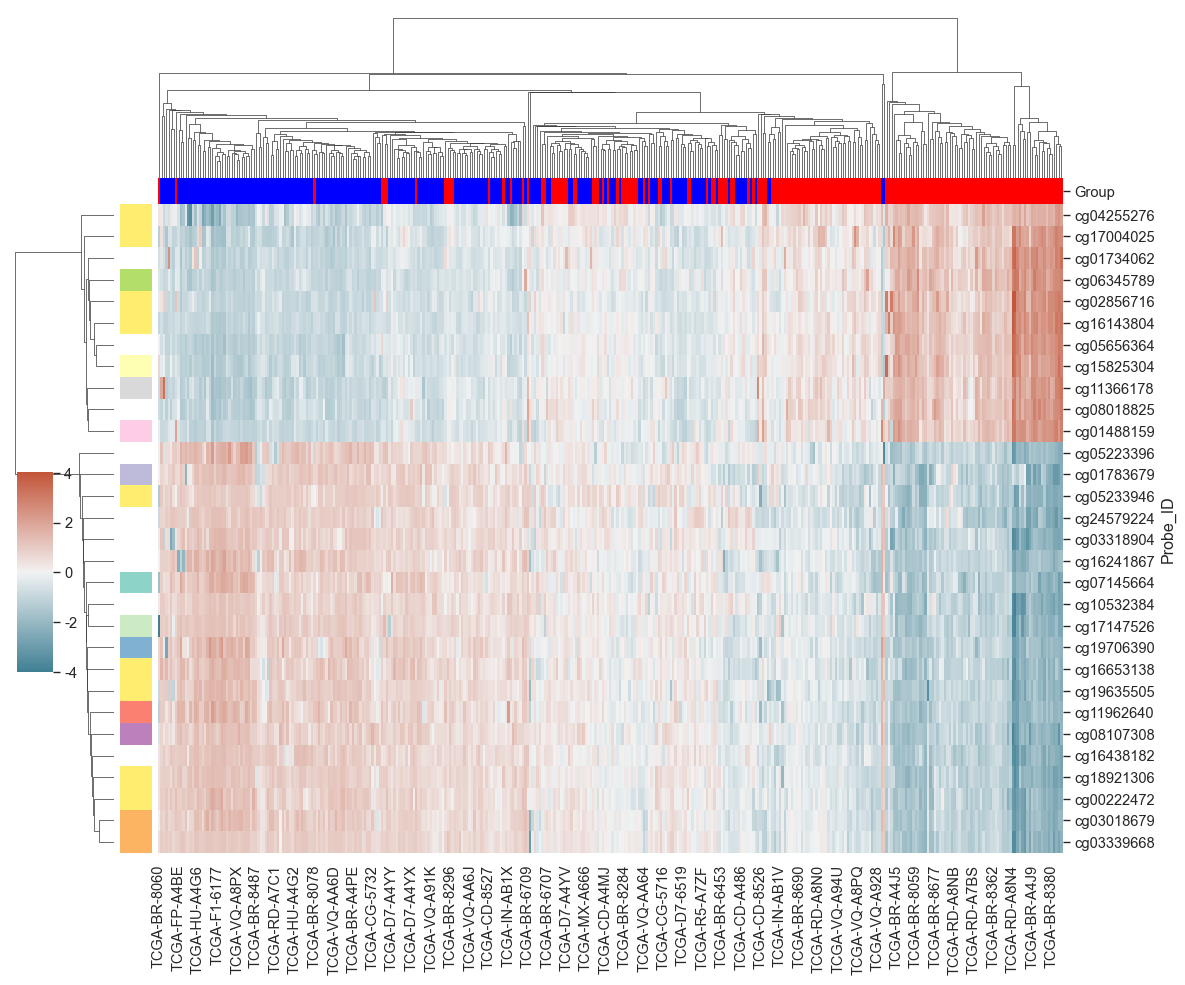

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# 设置文件路径
methylation_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_Methylation_Levels.csv"
expression_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_MIR100HG_Expression_Levels.csv"
probe_map_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA/probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy"

# 1. 读取数据
print("读取甲基化数据...")
meth_data = pd.read_csv(methylation_file, index_col=0)
print(f"甲基化数据形状: {meth_data.shape}")

print("读取表达数据...")
expr_data = pd.read_csv(expression_file)
print(f"表达数据形状: {expr_data.shape}")

# 2. 读取探针映射文件
print("读取探针映射数据...")
probe_map = pd.read_csv(probe_map_file, sep='\t', comment=None)
if probe_map.columns[0] == '#id':
    probe_map = probe_map.rename(columns={'#id': 'Probe_ID', 'gene': 'HGNC_Symbol'})
print(f"探针映射数据形状: {probe_map.shape}")
print(f"探针映射文件的列名: {probe_map.columns.tolist()}")

# 3. 样本 ID 格式统一函数（统一为 TCGA-XX-XXXX）
def convert_sample_id_dashed(sample_id):
    if isinstance(sample_id, str) and sample_id.startswith('TCGA'):
        sample_id = sample_id.replace('_', '-')  # 替换下划线为横杠
        parts = sample_id.split('-')
        if len(parts) >= 3:
            return f"TCGA-{parts[1]}-{parts[2]}"
    return sample_id

# 应用到甲基化数据的列名（去掉第四段，统一格式）
meth_data.columns = [convert_sample_id_dashed(col) for col in meth_data.columns]

# 应用到表达数据的 Patient_ID（统一格式）
expr_data['Patient_ID'] = expr_data['Patient_ID'].apply(convert_sample_id_dashed)

# 4. 根据MIR100HG的表达水平分组
print("根据MIR100HG表达分组...")
high_group = expr_data[expr_data['Group'] == 'High']['Patient_ID'].tolist()
low_group = expr_data[expr_data['Group'] == 'Low']['Patient_ID'].tolist()
print(f"高表达组: {len(high_group)}个样本")
print(f"低表达组: {len(low_group)}个样本")

# 5. 筛选共有样本，并调试打印
high_samples = [s for s in high_group if s in meth_data.columns]
low_samples = [s for s in low_group if s in meth_data.columns]

print(f"共有样本 - 高表达组: {len(high_samples)}个")
print(f"共有样本 - 低表达组: {len(low_samples)}个")

# 打印前几个匹配不成功的样本名进行调试
unmatched_high = [s for s in high_group if s not in meth_data.columns]
unmatched_low = [s for s in low_group if s not in meth_data.columns]

print("未匹配成功的高表达组样本示例:", unmatched_high[:5])
print("未匹配成功的低表达组样本示例:", unmatched_low[:5])
print("甲基化数据列名示例:", meth_data.columns[:5].tolist())

# 6. 差异甲基化分析
print("执行差异甲基化分析...")
results = []
for probe in meth_data.index:
    high_values = meth_data.loc[probe, high_samples].values
    low_values = meth_data.loc[probe, low_samples].values
    high_values = high_values[~np.isnan(high_values)]
    low_values = low_values[~np.isnan(low_values)]
    if len(high_values) >= 3 and len(low_values) >= 3:
        mean_diff = np.mean(high_values) - np.mean(low_values)
        t_stat, p_value = stats.ttest_ind(high_values, low_values, equal_var=False)
        results.append({'Probe_ID': probe, 'Mean_Diff': mean_diff, 'p_value': p_value})

# 转为 DataFrame
result_df = pd.DataFrame(results)

# 7. 多重检验校正 (FDR)
print("执行多重检验校正...")
if not result_df.empty:
    result_df['adj_p_value'] = multipletests(result_df['p_value'], method='fdr_bh')[1]
else:
    print("结果为空，未进行多重检验校正。")


# 8. 筛选显著差异位点（放宽阈值）
padj_threshold = 0.1               # 从0.05放宽到0.1
abs_mean_diff_threshold = 0.1      # 从0.2放宽到0.1

if not result_df.empty:
    sig_dmps = result_df[(result_df['adj_p_value'] < padj_threshold) &
                         (abs(result_df['Mean_Diff']) > abs_mean_diff_threshold)]
    print(f"显著差异的甲基化位点: {len(sig_dmps)}")
else:
    sig_dmps = pd.DataFrame()
    print("没有差异甲基化结果。")


# 9. 探针映射到基因
print("将探针映射到基因...")
probe_to_gene = dict(zip(probe_map['Probe_ID'], probe_map['HGNC_Symbol']))
if not sig_dmps.empty:
    sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))
    mapped_genes = sig_dmps['Gene'].value_counts()
    print(f"成功映射到基因的探针数量: {mapped_genes.shape[0] - (1 if 'Unknown' in mapped_genes else 0)}")

# 10. 保存结果
output_table_dir = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED"
os.makedirs(output_table_dir, exist_ok=True)

result_df.to_csv(os.path.join(output_table_dir, "STAD_DMA_All_Results.csv"), index=False)
if not sig_dmps.empty:
    sig_dmps.sort_values('adj_p_value').to_csv(os.path.join(output_table_dir, "STAD_DMA_Significant_Results.csv"), index=False)
    print("结果文件已保存。")
else:
    print("无显著结果，无文件输出。")

# 11. 热图可视化
print("生成热图可视化...")
output_fig_dir = os.path.join(output_table_dir, "Figure")
os.makedirs(output_fig_dir, exist_ok=True)

if not sig_dmps.empty:
    top_probes = sig_dmps.sort_values('adj_p_value').head(30)['Probe_ID'].tolist()
    heatmap_data = meth_data.loc[top_probes, high_samples + low_samples]
    sample_groups = pd.Series(['High'] * len(high_samples) + ['Low'] * len(low_samples),
                              index=high_samples + low_samples)
    row_annotations = pd.DataFrame({'Gene': [probe_to_gene.get(probe, 'Unknown') for probe in top_probes]},
                                   index=top_probes)
    col_annotations = pd.DataFrame({'Group': sample_groups})
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    g = sns.clustermap(heatmap_data,
                       cmap=cmap,
                       z_score=0,
                       row_colors=row_annotations['Gene'].astype('category').cat.codes.map({i: plt.cm.Set3(i) for i in range(20)}),
                       col_colors=col_annotations['Group'].map({'High': 'red', 'Low': 'blue'}),
                       figsize=(12, 10),
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(.02, .32, .03, .2))

    heatmap_file = os.path.join(output_fig_dir, "STAD_DMA_Heatmap.png")
    plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
    print(f"热图已保存为: {heatmap_file}")
else:
    print("没有足够的显著差异甲基化位点用于热图。")

# 12. 富集分析图（占位）
enrichment_plot_file = os.path.join(output_fig_dir, "STAD_DMA_Enrichment.png")
plt.savefig(enrichment_plot_file, dpi=300, bbox_inches='tight')
print(f"富集分析图已保存为: {enrichment_plot_file}")


# 📄 Promoter_Region 表说明

该表由原始文件 `geneAnnotation_hg19_basicgenes.txt` 清洗重命名而来，文件路径为：/Users/heweilin/Desktop/M-28/NTU_DATA_CLEANED/Promoter_Region.csv


---

## ✅ 字段修改记录

| 原始列名   | 新列名           | 说明                                 | 操作类型 |
|------------|------------------|--------------------------------------|----------|
| chr        | Promoter_Chr     | 启动子所在染色体                     | 重命名 ✅ |
| start      | Promoter_start   | 启动子起始位置（单位：bp）           | 重命名 ✅ |
| end        | Promoter_End     | 启动子终止位置（单位：bp）           | 重命名 ✅ |
| width      | Promoter_Width   | 启动子长度，通常为 1000              | 重命名 ✅ |
| strand     | ❌ 已删除         | DNA 链方向，对本分析无实际意义       | 删除 ✅   |
| id         | Promoter_ID      | 启动子编号（如 promoter:1）          | 重命名 ✅ |
| tx_id      | ❌ 已删除         | 来源注释标签，无分析用途             | 删除 ✅   |
| gene_id    | UCSC_ID          | UCSC Transcript ID，供转换基因名称用 | 重命名 ✅ |
| symbol     | ❌ 已删除         | 与 gene_id 重复                      | 删除 ✅   |
| type       | ❌ 已删除         | 多为 NA 或 Entrez ID，无需保留       | 删除 ✅   |
| –          | HGNC_Symbol      | UCSC_ID 映射得到的标准基因名         | ✅ 新增   |

---

## 📑 每列含义说明

| 列名             | 含义说明 |
|------------------|----------|
| Promoter_Chr     | 启动子所在染色体编号（如 chr1、chrX） |
| Promoter_Start   | 启动子区域在染色体上的起始位置（单位：bp） |
| Promoter_End     | 启动子区域在染色体上的终止位置（单位：bp） |
| Promoter_Width   | 启动子长度，默认 1000 bp |
| Promoter_ID      | 启动子区域的唯一编号（如 promoter:1） |
|  UCSC_Entrez_ID         | UCSC Transcript ID（如 uc001aaa.3），是转录本编号 |
| HGNC_Symbol      | 转录本对应的标准基因名称（如 A1BG、TP53） |

---

## 🧩 下游用途建议

- 与甲基化 probe 坐标匹配，判断是否命中启动子区域；
- 使用 `HGNC_Symbol` 可与基因表达数据、TF-target 网络直接关联；
- 可用于启动子富集分析、功能注释、调控网络构建等；
- 是启动子–甲基化–表达整合分析的关键注释资源。

---

## 🛠 HGNC Symbol 添加方法说明（基于 Python + MyGene）

使用 [MyGene.info](https://mygene.info) 进行 UCSC Transcript ID → HGNC Symbol 映射：
geneAnnotation_hg19_basicgenes.txt 中的 gene_id 实际上 有时是 UCSC transcript ID（如 uc001aaa.3）
但 有时是 Entrez Gene ID（如 100287102）
你希望统一把这一列命名为 UCSC_Entrez_ID，并用它智能转换为 HGNC Symbol：
如果是 UCSC transcript ID，就用 scopes='ucsc'
如果是 Entrez ID，就用 scopes='entrezgene'

### ▶️ 安装 `mygene` 库：

```bash
pip install mygene


In [14]:
!pip install mygene

In [16]:
import pandas as pd
import mygene
import os
import re

# === Step 0: 设置路径 ===
input_path = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA/geneAnnotation_hg19_basicgenes.txt'
output_dir = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/'
output_path = os.path.join(output_dir, 'Promoter_Region.csv')

# 创建输出目录（如果不存在）
os.makedirs(output_dir, exist_ok=True)

# === Step 1: 读取和清洗列 ===
df = pd.read_csv(input_path, sep='\t', dtype=str)

# 重命名列
df = df.rename(columns={
    'chr': 'Promoter_Chr',
    'start': 'Promoter_Start',
    'end': 'Promoter_End',
    'width': 'Promoter_Width',
    'id': 'Promoter_ID',
    'gene_id': 'UCSC_Entrez_ID'  # ✅ 重命名
})

# 删除不需要的列
df = df.drop(columns=['strand', 'tx_id', 'symbol', 'type'], errors='ignore')

# 删除空值
df = df[df['UCSC_Entrez_ID'].notnull() & (df['UCSC_Entrez_ID'].str.strip() != '')]

# === Step 2: 判断哪些是 UCSC ID，哪些是 Entrez ID ===
def is_ucsc(x):
    return bool(re.match(r'^uc\d+[a-z]+\d*$', x.strip().split('.')[0]))

df['ID_Type'] = df['UCSC_Entrez_ID'].apply(lambda x: 'ucsc' if is_ucsc(x) else 'entrezgene')
df['query_id'] = df['UCSC_Entrez_ID'].str.replace(r'\.\d+$', '', regex=True)  # 去掉版本号

# === Step 3: 使用 mygene 批量查询 ===
mg = mygene.MyGeneInfo()

# 分开查 UCSC 和 Entrez ID
results = []

for scope in ['ucsc', 'entrezgene']:
    ids_to_query = df[df['ID_Type'] == scope]['query_id'].unique().tolist()
    print(f"🔍 正在查询 {len(ids_to_query)} 个 {scope} ID...")
    res = mg.querymany(ids_to_query, scopes=scope, fields='symbol', species='human')
    results.extend(res)

# 转为 DataFrame
query_df = pd.DataFrame(results)

# 只保留成功映射的记录
query_df = query_df[query_df['symbol'].notnull() & query_df['query'].notnull()]
query_df = query_df[['query', 'symbol']].drop_duplicates()
query_df.columns = ['query_id', 'HGNC_Symbol']

# === Step 4: 合并回主表 ===
df = df.merge(query_df, on='query_id', how='left')
df = df.drop(columns=['ID_Type', 'query_id'])

# === Step 5: 保存 ===
df.to_csv(output_path, index=False)
print(f"✅ 处理完成！文件已保存至：{output_path}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🔍 正在查询 0 个 ucsc ID...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🔍 正在查询 23459 个 entrezgene ID...


135 input query terms found no hit:	['100133331', '100616489', '654348', '643314', '23285', '100130000', '728932', '728936', '200058', '


✅ 处理完成！文件已保存至：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Promoter_Region.csv


# 清洗gene_attribute_edges.txt

In [17]:
import pandas as pd

# 原始文件路径
input_path = r"/Users/heweilin/Desktop/M-28-STAD/NTU_DATA/gene_attribute_edges.txt"

# 新文件保存路径
output_path = r"/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/TF_Target.csv"

# 读取原始文件
df = pd.read_csv(input_path, sep="\t")

# 重命名所需的列
df = df.rename(columns={
    "source": "HGNC_Symbol",   # 被调控基因
    "source_id": "Gene_ID",    # 被调控基因的 ID
    "target": "TF_Symbol",            # 调控该基因的转录因子
    "target_id": "TF_ID"       # TF 的 ID
})

# 删除不需要的列
df = df.drop(columns=["source_desc", "target_desc", "weight"], errors="ignore")

# 保存为新文件（使用逗号分隔，即 CSV）
df.to_csv(output_path, index=False)

print("✅ 文件已保存为:", output_path)


/var/folders/6r/vh9hm9y50sng_kp683fc7t8m0000gn/T/ipykernel_72757/207374863.py:10: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path, sep="\t")


✅ 文件已保存为: /Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/TF_Target.csv


## 🔧 探针注释表预处理步骤

为确保后续分析中每个探针仅对应一个标准 HGNC 基因符号，我们对原始注释文件 `probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy` 进行了以下处理：

1. **重命名列名**：
   - `#id` → `Probe_ID`
   - `gene` → `HGNC_Symbol`
   - `chrom` → `Probe_Chr`
   - `chromStart` → `Probe_Chrom_Start`
   - `chromEnd` → `Probe_Chrom_End`
   - 删除无用列 `strand`

2. **拆分多基因注释**：
   - 原始文件中部分探针对应多个基因（如 `BNIPL,C1orf56`），用英文逗号`,`分隔；
   - 将这些记录按基因名拆分为多行，使得每一行探针仅对应一个 HGNC Symbol；
   - 其余探针信息（如染色体、位置）保持不变。

3. **去除空值与未注释基因**：
   - 删除 `HGNC_Symbol` 字段中为空或为 `.` 的记录。

4. **保存新文件**：
   - 处理后的文件保存为 `Probe_Map.csv`，路径为：
     ```
     /Users/heweilin/Desktop/M-28/NTU_DATA_CLEANED/Probe_Map.csv
     ```

该处理步骤确保了探针与基因之间的一对一映射关系，有利于后续基因水平的整合分析、功能注释和富集分析。


In [20]:
import pandas as pd
import os

# 设置文件路径
input_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA/probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy"
output_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Probe_Map.csv"

# 读取原始注释文件（制表符分隔）
df = pd.read_csv(input_file, sep='\t')

# 重命名列名
df = df.rename(columns={
    '#id': 'Probe_ID',
    'gene': 'HGNC_Symbol',
    'chrom': 'Probe_Chr',
    'chromStart': 'Probe_Chrom_Start',
    'chromEnd': 'Probe_Chrom_End'
})

# 删除 'strand' 列（如果存在）
if 'strand' in df.columns:
    df = df.drop(columns=['strand'])

# 拆分含有多个 HGNC_Symbol 的行（以逗号分隔）
df['HGNC_Symbol'] = df['HGNC_Symbol'].fillna('')
df_expanded = df.assign(HGNC_Symbol=df['HGNC_Symbol'].str.split(',')).explode('HGNC_Symbol')

# 去除空字符串（原始是 . 或 NaN）
df_expanded = df_expanded[df_expanded['HGNC_Symbol'].str.strip() != '']

# 重置索引并保存
df_expanded.reset_index(drop=True, inplace=True)
df_expanded.to_csv(output_file, index=False)

print(f"探针注释表已成功处理并保存为：{output_file}")


探针注释表已成功处理并保存为：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Probe_Map.csv


## ✅ 分析任务二：启动子甲基化定位分析

### 🎯 分析目标：
- 判断差异甲基化 probe 是否位于基因启动子区域；
- 联合表达数据，筛选出：
  - 启动子甲基化升高 + 表达下调；
  - 启动子甲基化下降 + 表达上升；
- 探索 MIR100HG 是否通过调控启动子甲基化间接影响基因表达。

---

### 📁 数据来源：

| 数据类型 | 文件路径 |
|----------|-----------|
| 差异甲基化结果（按 MIR100HG 分组） | `/PRAD_DMA_Significant_Results.csv` |
| 450K probe 注释文件 | `/Probe_Map.csv` |
| 启动子注释表（含 HGNC Symbol） | `/Promoter_Region.csv` |
| 差异表达数据（MIR100HG 分组） | `/PRAD_DEG_Significant_Results.csv` |

---

### 🛠 分析流程：

1. 合并差异甲基化表与 probe 注释信息，获得每个 probe 的染色体坐标；
2. 判断 probe 是否位于某个基因的启动子区域；
3. 映射出启动子甲基化变化所关联的基因；
4. 联合差异表达数据，识别具有以下联合变化趋势的关键基因：
   - 启动子甲基化↑ + 表达↓；
   - 启动子甲基化↓ + 表达↑。

---

### 📤 输出文件与统计：

| 文件名 | 内容说明 | 记录数 |
|--------|----------|--------|
| `Methylation_Probes_in_Promoters.csv` | 所有落在启动子区域的差异甲基化 probe | **1931** |
| `Promoters_Methylation_Up_Expression_Down.csv` | 启动子甲基化升高且表达下调的关键基因列表 | **0** |
| `Promoters_Methylation_Down_Expression_Up.csv` | 启动子甲基化下降且表达上升的候选基因 | **343** |

---

### 🧠 分析解读：

- 尽管有 **1931** 个差异甲基化 probe 命中启动子区域，但**没有基因同时满足“启动子甲基化升高 + 表达显著下调”的双重标准**；
- 相反，发现了 **343 个基因具有“启动子甲基化下降 + 表达上升”趋势**，提示甲基化可能在这些基因中起到了“表达抑制解除”的调控作用；
- 从调控方向上看，**MIR100HG 高表达个体中**可能更倾向于通过降低某些基因启动子甲基化，从而**激活**其表达；
- 这些结果为进一步研究 MIR100HG 的功能调控提供了候选目标基因，值得在后续分析中深入探索。


In [34]:
import pandas as pd
import os

# ======= 设置路径 ========
dma_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DMA_Significant_Results.csv"
probe_map_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Probe_Map.csv"
promoter_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Promoter_Region.csv"
deg_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DEG_Significant_Results.csv"
output_dir = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED"

os.makedirs(output_dir, exist_ok=True)

# ======= 读取数据 ========
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)

# ======= 合并 DMA 和 Probe 坐标 ========
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# ======= 判断 Probe 是否落在启动子区域 ========
matched = []

for _, row in dma_annotated.iterrows():
    hits = promoter_df[
        (promoter_df['Promoter_Chr'] == row['Probe_Chr']) &
        (promoter_df['Promoter_Start'] <= row['Probe_Chrom_Start']) &
        (promoter_df['Promoter_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

# 转换为 DataFrame
promoter_hits_df = pd.DataFrame(matched)

# ======= 保存所有启动子内 Probe ========
promoter_hits_path = os.path.join(output_dir, "STAD_Methylation_Probes_in_Promoters.csv")
promoter_hits_df.to_csv(promoter_hits_path, index=False)
print(f"✅ 所有启动子区域的 probe 保存至：{promoter_hits_path}")

# ======= 联合 DEG 表达数据 ========
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = promoter_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# ======= 启动子甲基化↑ + 表达↓ 筛选 ========
up_meth_down_expr = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

up_meth_down_path = os.path.join(output_dir, "STAD_Promoters_Methylation_Up_Expression_Down.csv")
up_meth_down_expr.to_csv(up_meth_down_path, index=False)
print(f"✅ 启动子甲基化↑ + 表达↓ 的基因保存至：{up_meth_down_path}")

# ======= 启动子甲基化↓ + 表达↑ 筛选 ========
down_meth_up_expr = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

down_meth_up_path = os.path.join(output_dir, "STAD_Promoters_Methylation_Down_Expression_Up.csv")
down_meth_up_expr.to_csv(down_meth_up_path, index=False)
print(f"✅ 启动子甲基化↓ + 表达↑ 的基因保存至：{down_meth_up_path}")


✅ 所有启动子区域的 probe 保存至：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_Methylation_Probes_in_Promoters.csv
✅ 启动子甲基化↑ + 表达↓ 的基因保存至：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_Promoters_Methylation_Up_Expression_Down.csv
✅ 启动子甲基化↓ + 表达↑ 的基因保存至：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_Promoters_Methylation_Down_Expression_Up.csv


## 🧬 基因体区域注释表说明（`Gene_Region.csv`）

为实现对**非启动子区域（尤其是基因体区域）**甲基化探针的精准定位，我们构建了 `Gene_Region.csv` 表。该表基于 Ensembl GRCh38 基因组注释（release 109）自动提取，包含全基因的坐标信息，具体字段如下：

| 列名          | 含义说明                               |
|---------------|----------------------------------------|
| `HGNC_Symbol` | 基因标准名称（如 TP53、BRCA1）         |
| `Gene_Chr`    | 基因所在的染色体编号（如 chr1, chr17） |
| `Gene_Start`  | 基因在染色体上的起始位置（1-based）    |
| `Gene_End`    | 基因在染色体上的结束位置               |

---

### 🧠 使用目的：

我们后续的分析目标是识别**位于基因体区域**的甲基化探针（即不在启动子区域、但在基因结构范围内），并进一步联合表达数据挖掘：

- **基因体甲基化升高 + 表达下调**（可能具有调控功能）；
- **基因体甲基化下降 + 表达上调**（可能解除沉默）；

通过构建 `Gene_Region.csv`，我们可以精确判断每个差异甲基化 probe 是否命中某个基因体区域，从而避免将非功能区（如 intergenic 区域）误认为基因相关调控位点。


In [35]:
import pandas as pd
import gzip
import requests
import os

# ========== Step 1: 下载 GTF 文件（Ensembl GRCh38） ==========
gtf_url = "http://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.gtf.gz"
gtf_path = "Homo_sapiens.GRCh38.109.gtf.gz"

if not os.path.exists(gtf_path):
    print("🔽 正在下载 GTF 文件...")
    r = requests.get(gtf_url, stream=True)
    with open(gtf_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("✅ 下载完成！")

# ========== Step 2: 提取 gene 区域 ==========
genes = []
with gzip.open(gtf_path, 'rt') as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if parts[2] != "gene":
            continue
        chr_, source, type_, start, end, score, strand, phase, attributes = parts
        attr_dict = {k.strip(): v.strip('"') for k, v in [field.strip().split(" ") for field in attributes.strip(";").split(";") if field]}
        if 'gene_name' in attr_dict:
            # 标准化染色体格式为 chrN
            chr_fixed = chr_ if chr_.startswith("chr") else f"chr{chr_}"
            gene = {
                "HGNC_Symbol": attr_dict['gene_name'],
                "Gene_Chr": chr_fixed,
                "Gene_Start": int(start),
                "Gene_End": int(end)
            }
            genes.append(gene)

# ========== Step 3: 保存为指定位置的 Gene_Region.csv ==========
output_path = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Gene_Region.csv"
gene_df = pd.DataFrame(genes)
gene_df = gene_df[gene_df["Gene_Chr"].str.startswith("chr")]  # 保留标准染色体格式
gene_df.to_csv(output_path, index=False)
print(f"📁 基因体注释文件已保存至：{output_path}")


📁 基因体注释文件已保存至：/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Gene_Region.csv


## ✅ 分析任务三：基因体区域甲基化定位分析

### 🎯 分析目标：
- 判断差异甲基化 probe 是否位于启动子区域之外的**基因体区域**；
- 联合表达数据，筛选出：
  - 启动子外甲基化升高 + 表达下调；
  - 启动子外甲基化下降 + 表达上升；
- 探索 MIR100HG 是否通过调控基因体区域甲基化间接影响基因表达活性。

---

### 📁 数据来源：

| 数据类型 | 文件路径 |
|----------|-----------|
| 差异甲基化结果（按 MIR100HG 分组） | `/PRAD_DMA_Significant_Results.csv` |
| 450K probe 注释文件 | `/Probe_Map.csv` |
| 启动子注释表（含 HGNC Symbol） | `/Promoter_Region.csv` |
| 基因体区域注释表 | `/Gene_Region.csv` |
| 差异表达数据（MIR100HG 分组） | `/PRAD_DEG_Significant_Results.csv` |

---

### 🛠 分析流程：

1. 合并差异甲基化表与 probe 注释信息，获得每个 probe 的染色体位置；
2. 排除位于启动子区域的 probe，筛选落入基因体区域（gene body）的探针；
3. 获取每个基因体 probe 对应的基因；
4. 联合差异表达数据，识别出可能受 gene body 甲基化调控的关键候选基因，包括：
   - 基因体甲基化↑ + 表达↓；
   - 基因体甲基化↓ + 表达↑。

---

### 📤 输出文件与统计：

| 文件名 | 内容说明 |
|--------|----------|
| `Methylation_Probes_in_GeneBody.csv` | 所有落在基因体区域的差异甲基化 probe |
| `GeneBody_Methylation_Up_Expression_Down.csv` | 启动子外甲基化升高且表达下调的候选基因 |
| `GeneBody_Methylation_Down_Expression_Up.csv` | 启动子外甲基化下降且表达上升的候选基因 |

---

### 🧠 分析解读：

- 此分析聚焦于启动子以外的潜在调控区域，尤其是基因体（gene body），这些区域的甲基化变化也可能影响转录效率；
- 筛选结果可帮助我们识别 MIR100HG 高表达样本中可能因**基因体甲基化变化**而发生表达改变的靶基因；
- 相较于启动子分析，该方法补充了甲基化调控网络的另一维度，有助于全面理解 MIR100HG 的下游作用机制；
- 后续可结合通路富集分析或可视化进一步挖掘这些候选基因的功能背景。



In [ ]:
import pandas as pd

# ======= 路径配置 =======
dma_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DMA_Significant_Results.csv"
probe_map_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Probe_Map.csv"
promoter_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Promoter_Region.csv"
deg_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/STAD_DEG_Significant_Results.csv"
gene_region_file = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED/Gene_Region.csv"
output_dir = "/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED"

# ======= 数据读取 =======
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)
gene_region_df = pd.read_csv(gene_region_file)

# 合并 probe 坐标信息
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# 筛除启动子区域内 probe
promoter_probes = set()
for _, row in promoter_df.iterrows():
    hits = dma_annotated[
        (dma_annotated['Probe_Chr'] == row['Promoter_Chr']) &
        (dma_annotated['Probe_Chrom_Start'] >= row['Promoter_Start']) &
        (dma_annotated['Probe_Chrom_End'] <= row['Promoter_End'])
    ]
    promoter_probes.update(hits['Probe_ID'].tolist())

non_promoter_df = dma_annotated[~dma_annotated['Probe_ID'].isin(promoter_probes)]

# 匹配基因体区域
matched = []
for _, row in non_promoter_df.iterrows():
    hits = gene_region_df[
        (gene_region_df['Gene_Chr'] == row['Probe_Chr']) &
        (gene_region_df['Gene_Start'] <= row['Probe_Chrom_Start']) &
        (gene_region_df['Gene_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

gene_body_hits_df = pd.DataFrame(matched)

# 联合 DEG 表达数据
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = gene_body_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# 启动子外甲基化下降 + 表达上升
hypo_up = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

# 启动子外甲基化上升 + 表达下调
hyper_down = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

# 保存结果
hypo_up.to_csv(f"{output_dir}/STAD_GeneBody_Methylation_Down_Expression_Up.csv", index=False)
hyper_down.to_csv(f"{output_dir}/STAD_GeneBody_Methylation_Up_Expression_Down.csv", index=False)
gene_body_hits_df.to_csv(f"{output_dir}/STAD_Methylation_Probes_in_GeneBody.csv", index=False)

print("✅ 分析完成，结果已保存：")
print(" - 启动子外甲基化下降 + 表达上升 → STAD_GeneBody_Methylation_Down_Expression_Up.csv")
print(" - 启动子外甲基化上升 + 表达下调 → STAD_GeneBody_Methylation_Up_Expression_Down.csv")
print(" - 所有命中基因体区域的 probe → STAD_Methylation_Probes_in_GeneBody.csv")


# DNA甲基化与基因表达关系分析报告

## 主要发现

### 启动子区域甲基化
- 总共有**1931个**差异甲基化探针位于启动子区域
- **95%**的探针显示甲基化下降（1834个探针），仅**5%**显示甲基化上升（97个探针）
- 甲基化变化范围从-0.255到0.221，平均变化为-0.191，表明整体趋势是甲基化水平下降

### 启动子甲基化与基因表达的关系
- 有**343个**基因同时满足"启动子甲基化下降+表达上升"的双重标准
- 这些基因的平均甲基化变化为-0.216
- 表达上调的Log2倍数变化在1.03到1.81之间，平均为1.31
- **没有**基因满足"启动子甲基化上升+表达下调"的模式（0个）

### 基因体甲基化
- 仅有**45个**差异甲基化探针位于基因体区域
- **8个**基因符合"基因体甲基化下降+表达上升"的模式
- 样本数据显示，这些基因的甲基化降低约为-0.2到-0.24
- 表达变化显著，如KIAA1210基因Log2倍数变化达2.24
- **没有**基因满足"基因体甲基化上升+表达下调"的模式（0个）

## 综合解释

1. **启动子甲基化的主导作用**：数据强烈支持启动子区域甲基化下降导致基因表达上调的调控模式。这与经典模型一致：启动子去甲基化→转录因子能够结合→基因表达激活。

2. **基因体甲基化的反常模式**：虽然传统观点认为基因体甲基化上升可能促进表达，但数据显示了相反的模式：基因体甲基化下降与表达上升相关。这可能表明在研究的特定生物学背景下，基因体甲基化机制与一般模型不同。

3. **单向调控趋势**：数据显示甲基化调控呈现明显的单向性——主要是通过去甲基化来激活基因表达，而不是通过增加甲基化来抑制表达。

4. **MIR100HG的潜在调控机制**：基于这些发现，MIR100HG高表达个体确实主要通过降低基因启动子区域的甲基化水平来激活基因表达，而非通过增加甲基化来抑制基因表达。

这些结果表明，在研究背景下，甲基化调控主要作为一种"解除抑制"的机制，而非"主动抑制"的机制，这对理解MIR100HG的功能及其下游效应具有重要意义。

In [38]:
"""
Author: Weilin He
Description: Reads and analyzes CSV files related to methylation and expression data.
"""

import pandas as pd
import numpy as np
import os

# Directory containing the CSV files
base_dir = '/Users/heweilin/Desktop/M-28-STAD/NTU_DATA_CLEANED'

# List of CSV files to process
files = [
    'STAD_GeneBody_Methylation_Down_Expression_Up.csv',
    'STAD_GeneBody_Methylation_Up_Expression_Down.csv',
    'STAD_Methylation_Probes_in_GeneBody.csv',
    'STAD_Methylation_Probes_in_Promoters.csv',
    'STAD_Promoters_Methylation_Down_Expression_Up.csv',
    'STAD_Promoters_Methylation_Up_Expression_Down.csv'
]

results = {}

# Function to load and analyze CSV files
def analyze_csv(file_path):
    df = pd.read_csv(file_path)
    analysis = {
        'row_count': len(df),
        'column_names': df.columns.tolist(),
        'sample_data': df.head(3).to_dict(orient='records')
    }

    # Detailed analysis for specific files
    if 'Methylation_Probes_in_GeneBody.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean()
        }

    if 'Methylation_Probes_in_Promoters.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        positive = (mean_diff > 0).sum()
        negative = (mean_diff < 0).sum()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean(),
            'positive_count': positive,
            'negative_count': negative,
            'positive_percentage': f"{positive / len(mean_diff) * 100:.2f}%",
            'negative_percentage': f"{negative / len(mean_diff) * 100:.2f}%"
        }

    if 'Promoters_Methylation_Down_Expression_Up.csv' in file_path:
        log2fc = df['Log2_Fold_Change'].dropna()
        mean_diff = df['Mean_Diff'].dropna()
        analysis['expression_stats'] = {
            'min_log2fc': log2fc.min(),
            'max_log2fc': log2fc.max(),
            'avg_log2fc': log2fc.mean(),
            'avg_mean_diff': mean_diff.mean()
        }

    return analysis

# Process each file
for file in files:
    file_path = os.path.join(base_dir, file)
    try:
        results[file] = analyze_csv(file_path)
    except Exception as e:
        results[file] = {'error': str(e)}

# Generate summary statistics
summary = {
    'total_promoter_probes': results.get('STAD_Methylation_Probes_in_Promoters.csv', {}).get('row_count', 0),
    'total_gene_body_probes': results.get('STAD_Methylation_Probes_in_GeneBody.csv', {}).get('row_count', 0),
    'promoter_methyl_down_expr_up': results.get('STAD_Promoters_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'promoter_methyl_up_expr_down': results.get('STAD_Promoters_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0),
    'gene_body_methyl_down_expr_up': results.get('STAD_GeneBody_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'gene_body_methyl_up_expr_down': results.get('STAD_GeneBody_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0)
}

# Display results
print("Summary of Analysis:", summary)

if 'STAD_Promoters_Methylation_Down_Expression_Up.csv' in results:
    print("Detailed Expression Stats (Promoters Down Methylation & Expression Up):", 
          results['STAD_Promoters_Methylation_Down_Expression_Up.csv'].get('expression_stats', {}))

if 'STAD_GeneBody_Methylation_Down_Expression_Up.csv' in results:
    print("Gene Body Row Count:", results['STAD_GeneBody_Methylation_Down_Expression_Up.csv']['row_count'])
    print("Gene Body Sample Data:", results['STAD_GeneBody_Methylation_Down_Expression_Up.csv']['sample_data'])

if 'STAD_Methylation_Probes_in_Promoters.csv' in results:
    print("Promoter Region Methylation Distribution:", 
          results['STAD_Methylation_Probes_in_Promoters.csv'].get('mean_diff_stats', {}))

print("Count of Promoter Methylation Up & Expression Down Genes:", 
      summary['promoter_methyl_up_expr_down'])


Summary of Analysis: {'total_promoter_probes': 688, 'total_gene_body_probes': 25, 'promoter_methyl_down_expr_up': 198, 'promoter_methyl_up_expr_down': 28, 'gene_body_methyl_down_expr_up': 0, 'gene_body_methyl_up_expr_down': 0}
Detailed Expression Stats (Promoters Down Methylation & Expression Up): {'min_log2fc': 1.0087803921568628, 'max_log2fc': 3.961178431372549, 'avg_log2fc': 1.9778995345613, 'avg_mean_diff': -0.23149610528360529}
Promoter Region Methylation Distribution: {'min': -0.3264461538461536, 'max': 0.2481557692307691, 'avg': -0.10192146131484793, 'positive_count': 201, 'negative_count': 487, 'positive_percentage': '29.22%', 'negative_percentage': '70.78%'}
Count of Promoter Methylation Up & Expression Down Genes: 28
